In [44]:
import faiss
import os
import numpy as np
from IPython.display import display, Image
from PIL import Image as PILImage
import lmdb
import torch 
import io
from misc.model import joint_embedding
from torchvision import transforms
from misc.utils import save_obj, collate_fn_cap_padded, encode_sentence


ModuleNotFoundError: No module named 'tqdm'

In [17]:
device = torch.device("cuda")
index_path = "/data/a.nivaggioli/features/Flat_CC_correct_full_cs.index"
db_path = "/data/a.nivaggioli/features/db_CC_correct_full_cs"
model_path = "weights/best_correct_full_cs.pth.tar"
dict_path = "/data/m.portaz/wiki.multi.en.vec"

In [18]:
def ShowImages(images):
    for ima in images:
        display(Image(ima))

In [19]:
index = faiss.read_index(str(index_path))
index_search = index.search

In [20]:
checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)

join_emb = joint_embedding(checkpoint['args_dict'])
join_emb.load_state_dict(checkpoint["state_dict"])

for param in join_emb.parameters():
    param.requires_grad = False

join_emb.to(device)
join_emb.eval()


normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

prepro_val = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    normalize,
])


tf_img = prepro_val

In [21]:
def load_vec(emb_path):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id
embeddings, id2word, word2id = load_vec(dict_path)

In [22]:
def get_features_sentence(sentence):
    input_sentence = encode_sentence(sentence, embeddings, word2id)
    input_caps = input_sentence.unsqueeze(0).to(device)
    print(input_caps.shape)

    with torch.no_grad():
        _, output_emb = join_emb(None, input_caps, [len(sentence.split(' '))])
    return output_emb.detach().cpu().numpy()

In [23]:
def neighbours_text(sentence, nb_images):
    features = get_features_sentence(sentence)
    env_images = lmdb.open(db_path,
                    max_dbs=2,
                    map_size=1e12,
                    lock=False,
                    readonly=True)
    paths_images_db = env_images.open_db(b'paths')
    with env_images.begin(write=False) as txn_images:
        paths = txn_images.cursor(paths_images_db)

        dists, uuids = index_search(features,nb_images)
        dists = dists.reshape(-1)
        uuids = uuids.reshape(-1)
        uuids = [str(u).encode() for u in uuids]

        images_paths = [paths.get(u).decode() for u in uuids]
    print(images_paths)
    ShowImages(images_paths)

In [24]:
def get_features_image(image_path):
    img = PILImage.open(image_path, mode="r")

    if img.mode is 'L':
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
        img = rgbimg
    if img.mode is not 'RGB':
        img = img.convert('RGB')

    img = tf_img(img)

    input_img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output, _ = join_emb(input_img, None, None)
    return output.detach().cpu().numpy()

In [25]:
def neighbours_image(image_path, nb_images):
    features = get_features_image(image_path)
    env_images = lmdb.open(db_path,
                    max_dbs=2,
                    map_size=1e12,
                    lock=False,
                    readonly=True)
    paths_images_db = env_images.open_db(b'paths')
    with env_images.begin(write=False) as txn_images:
        paths = txn_images.cursor(paths_images_db)

        dists, uuids = index_search(features,nb_images)
        dists = dists.reshape(-1)
        uuids = uuids.reshape(-1)
        uuids = [str(u).encode() for u in uuids]

        images_paths = [paths.get(u).decode() for u in uuids]
    print(images_paths)
    ShowImages(images_paths)

torch.Size([1, 4, 300])
['/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0002082965.jpg', '/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0001916377.jpg', '/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0001830516.jpg', '/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0001226820.jpg', '/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0003002751.jpg']


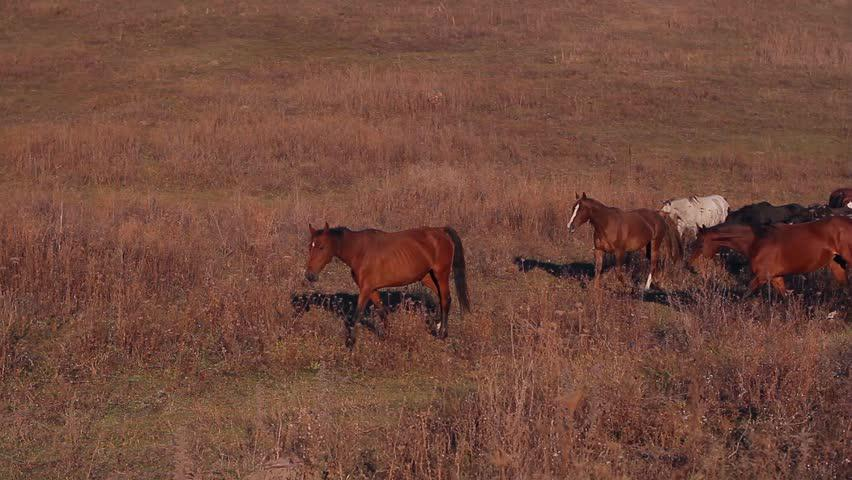

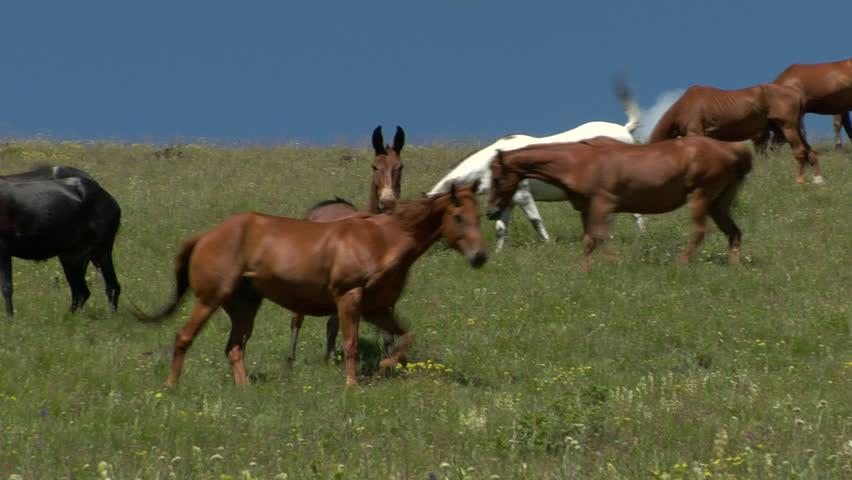

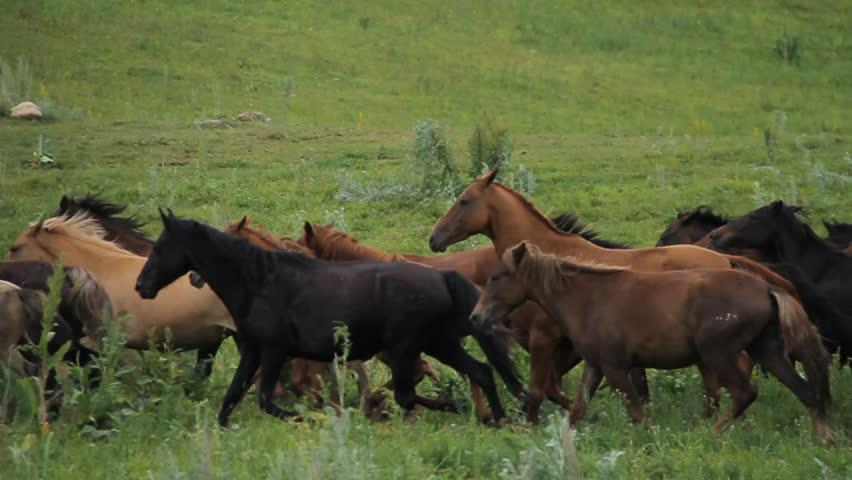

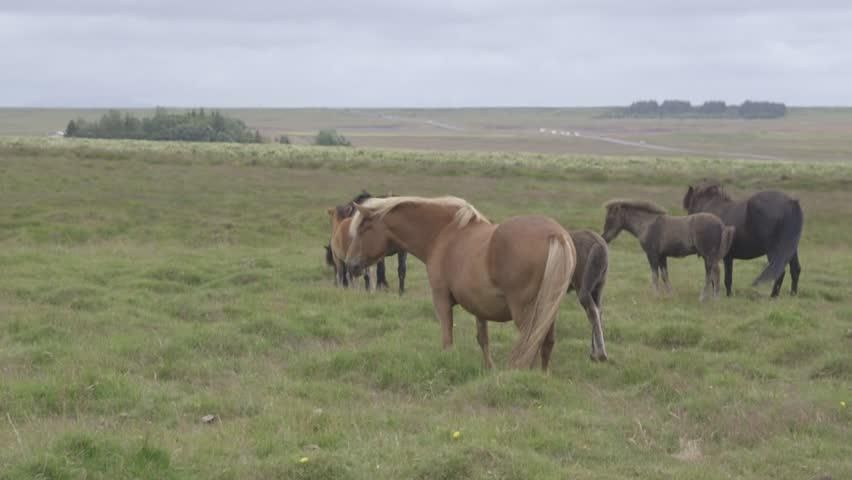

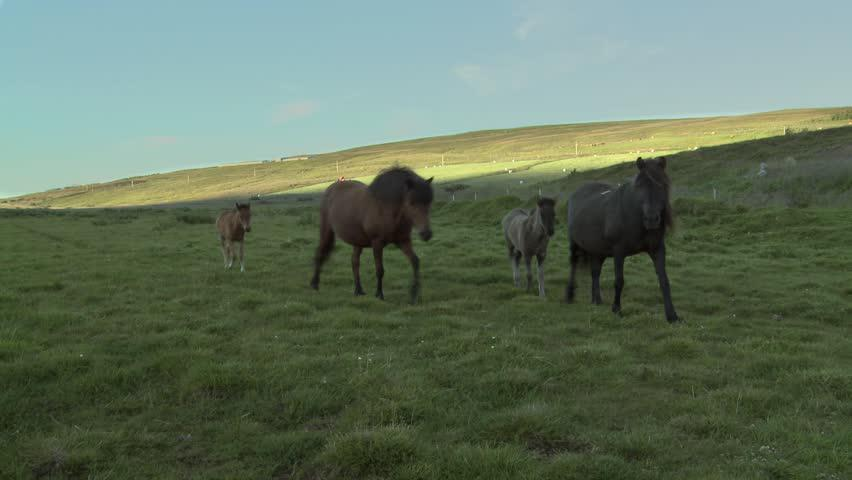

In [41]:
neighbours_text("horses in open field", 5)

['/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0001506959.jpg', '/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0000108419.jpg', '/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0000068425.jpg', '/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0001423275.jpg', '/data/a.nivaggioli/Datasets/ConceptualCaptions/Images/0001548114.jpg']


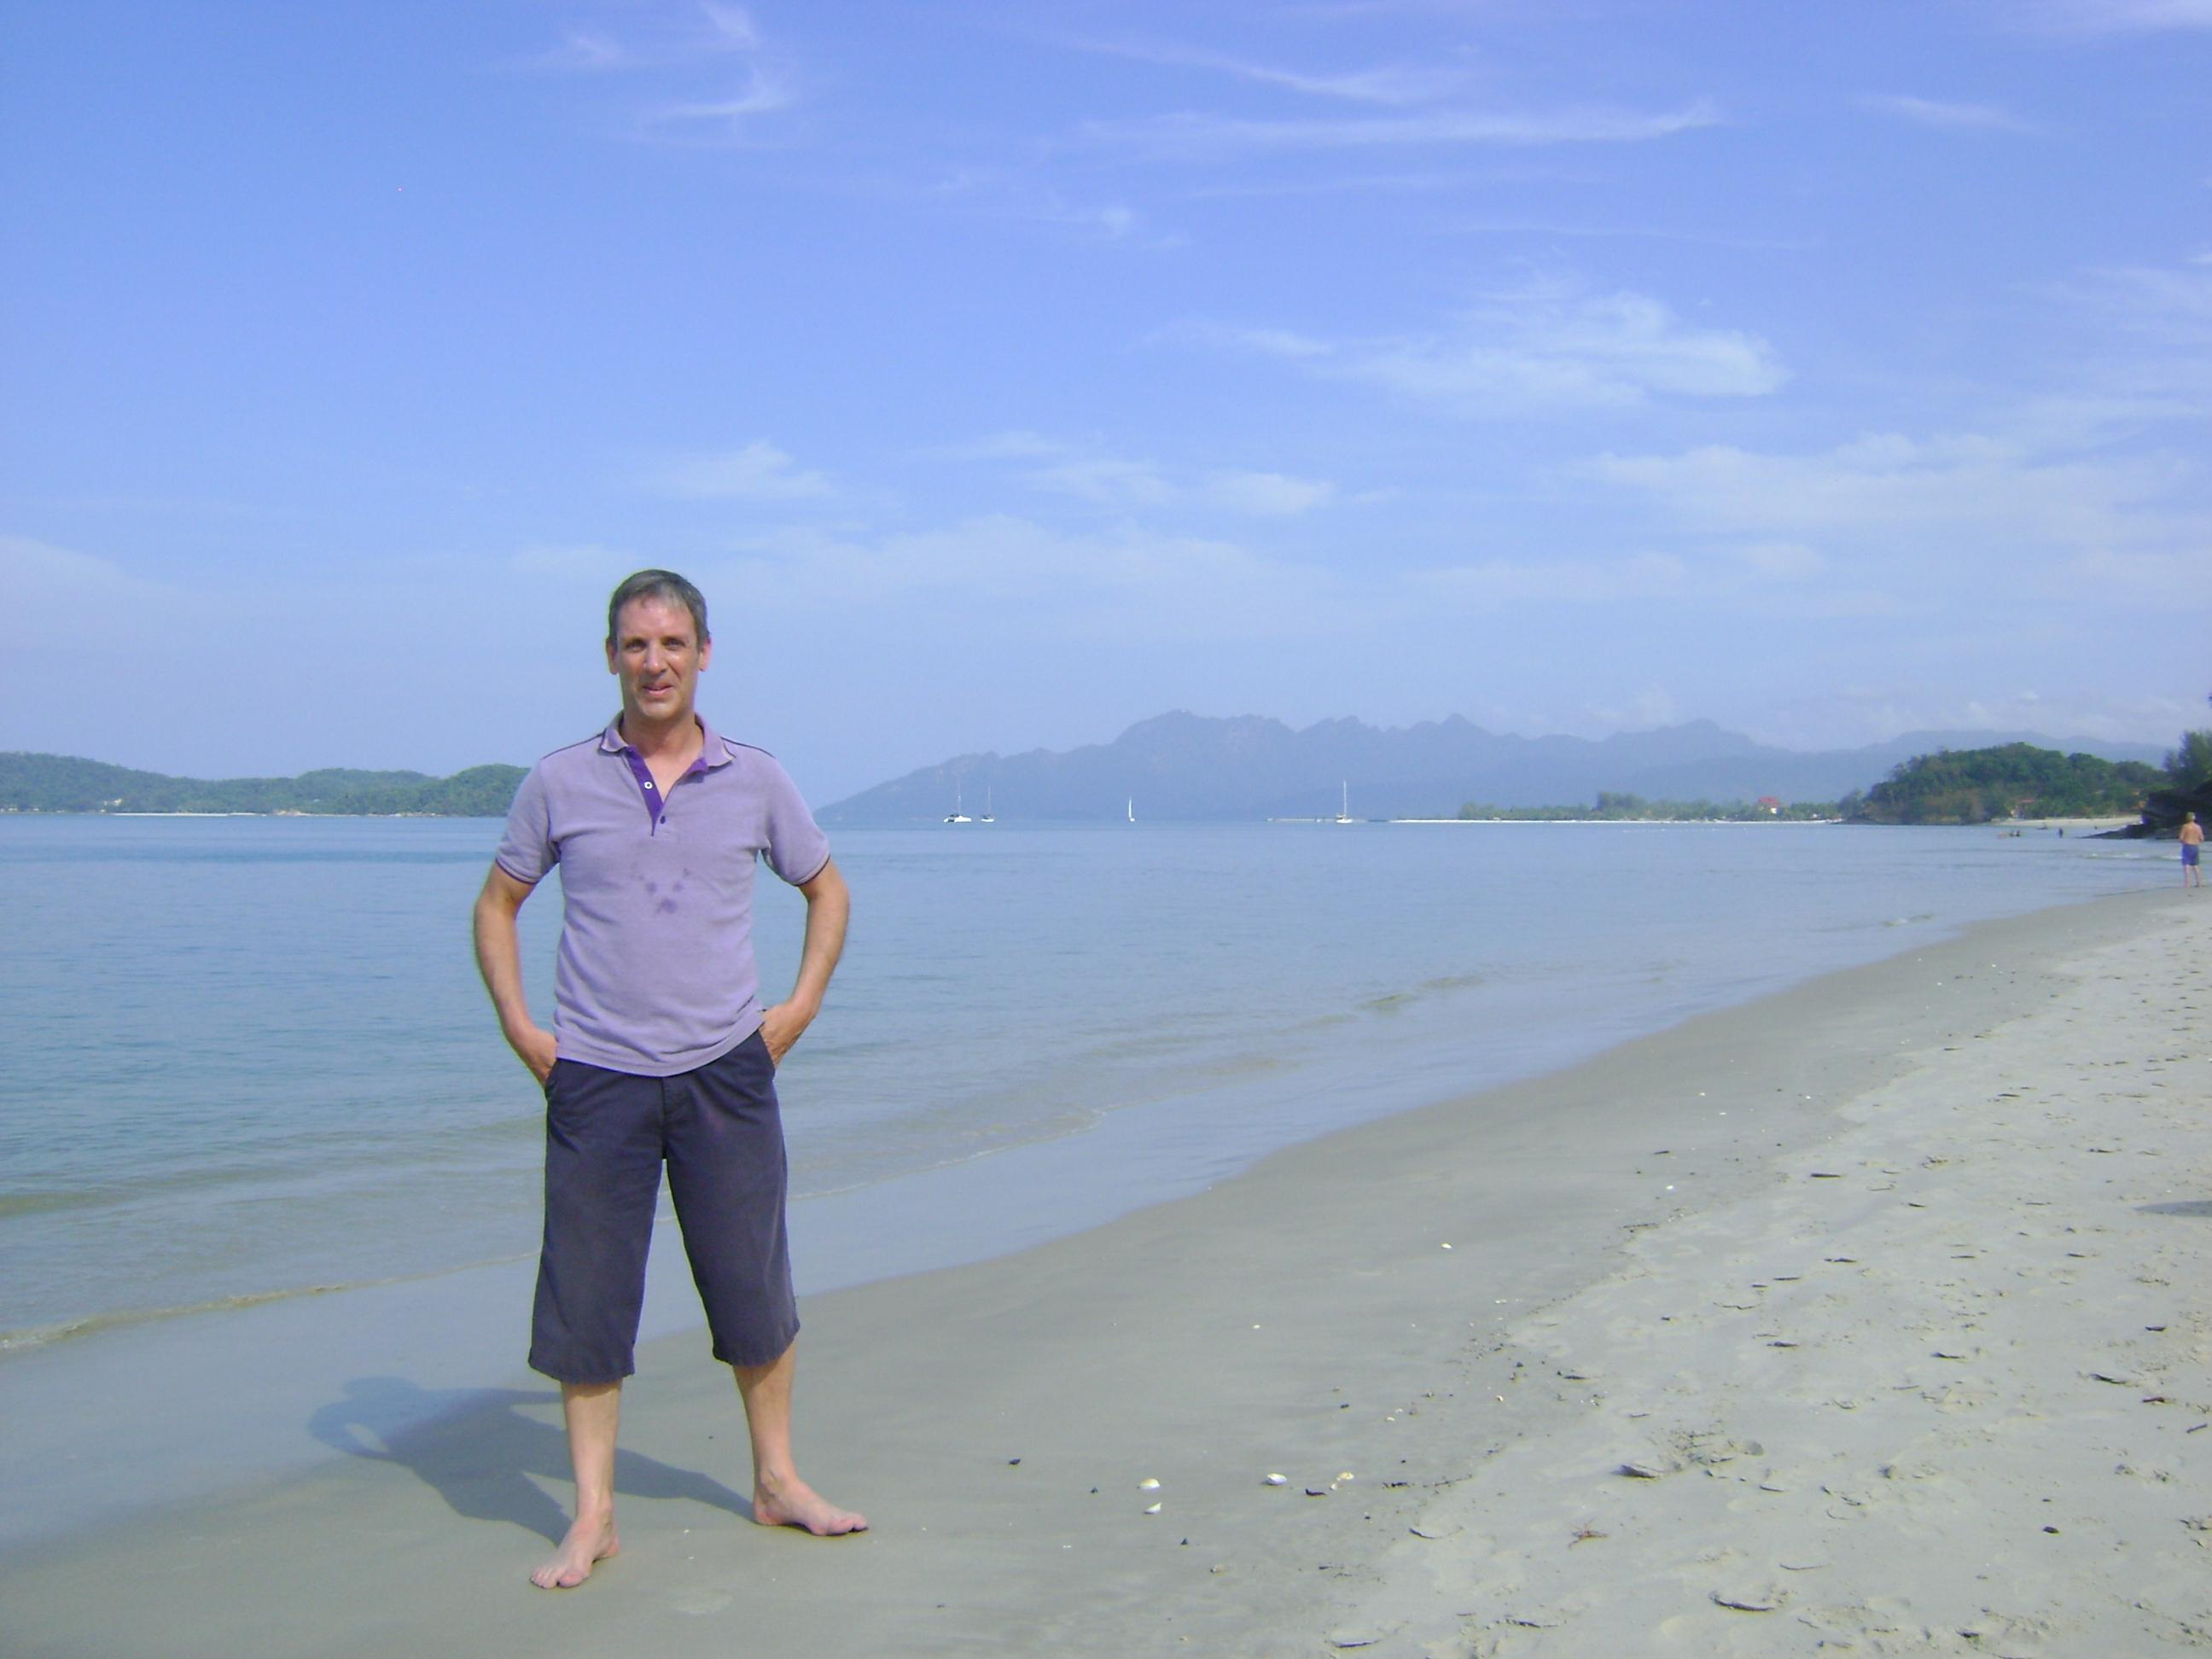

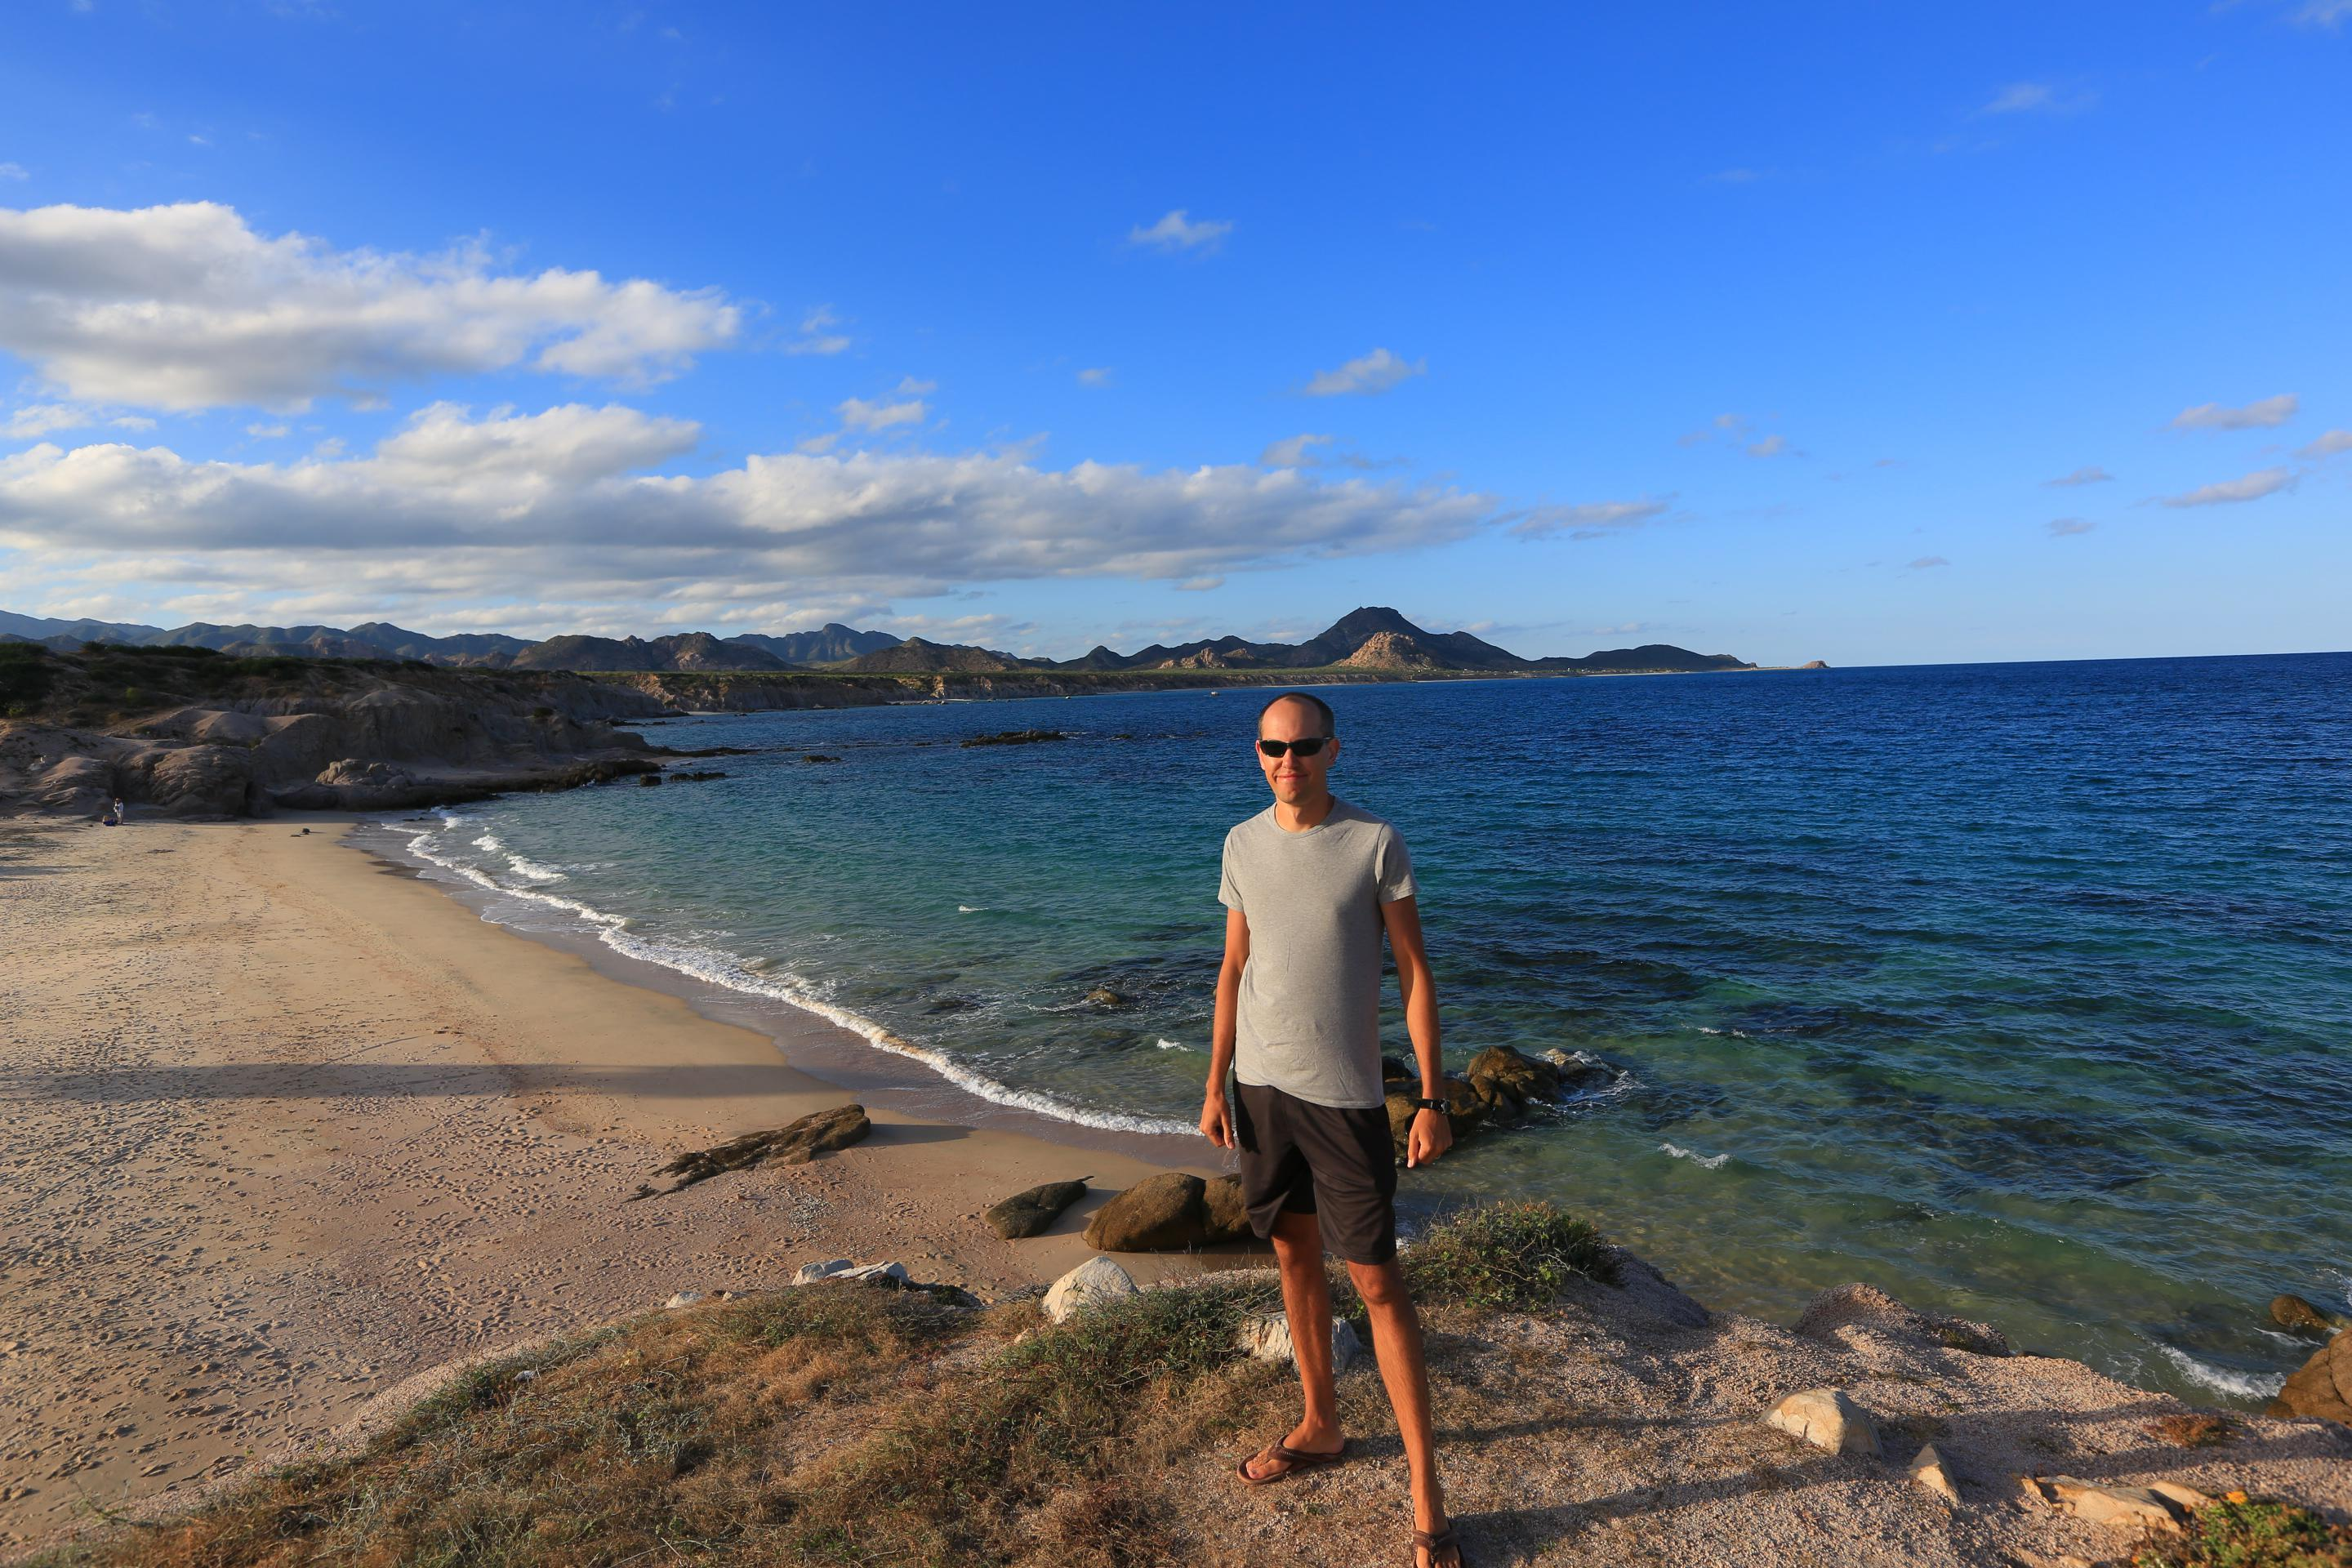

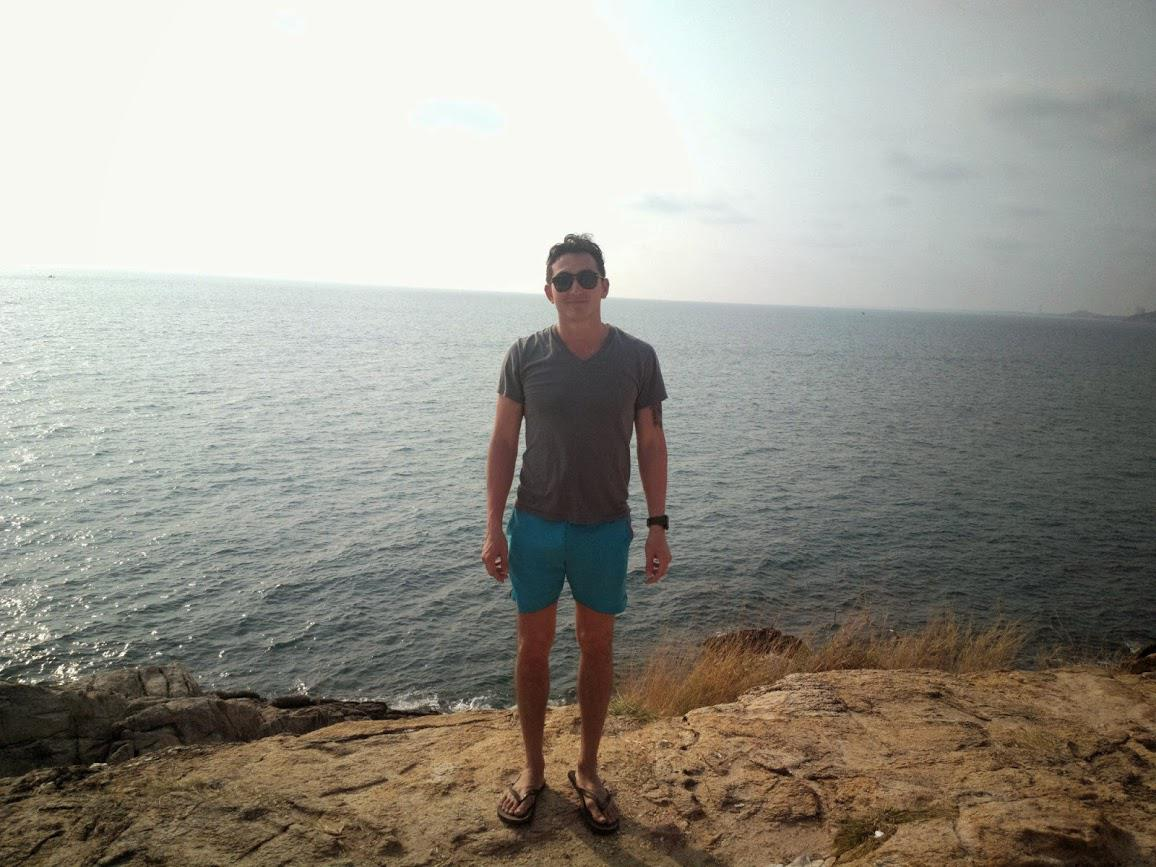

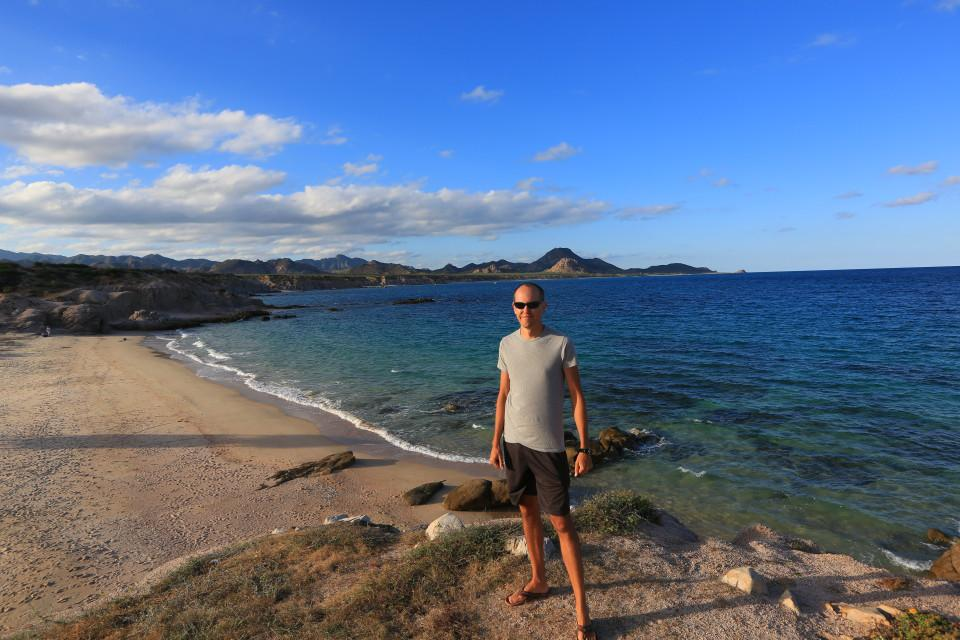

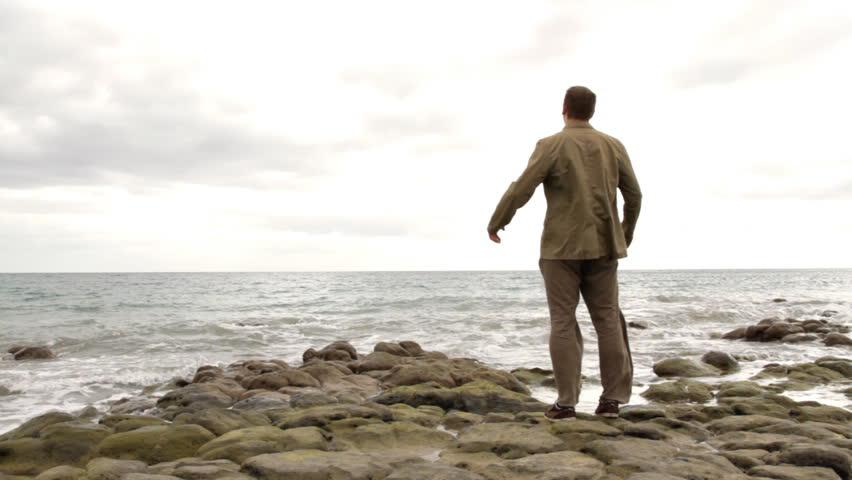

In [30]:

neighbours_image('/data/a.nivaggioli/features/manWalkingOnBeach.png',5)
